In [199]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 7)

Populating the interactive namespace from numpy and matplotlib


# Establish Connection To MongoDB

In this section, we demonstrate how to open a connection to MongoDB using pymongo. To do so, we will use the name of the application, 'squall', to connect to the correct database and the name of the experiment we want to query to extract the correct collection of documents (job results). Additional details for pymongo can be found in the official [documentation](https://docs.mongodb.org/getting-started/python/client/).

In [119]:
# Database Parameters
db_name = 'squall'  # Name of Application
coll_name = 'Fibonacci Demo'  # Name of Experiment

In [120]:
# Connect to database and extract collection
client = MongoClient("localhost", 27017)
db = client[db_name]
coll = db[coll_name]

# Fromatting Data With MongoDB & Pandas

The Pandas DataFrame structure in python makes exploration and analysis of results a breeze. While there are countless ways to go about analyzing your data, this method is particularly quick and easy. The following sections demonstrate how to go about getting your data from MongoDB into a DataFrame.

## Writing Queries & Creating DataFrames

 In this section, we will query MongoDB for all results where param A is equal to param B and create a separate DataFrame for results generated with different implementations (MATLAB, Python, or R).

### MATLAB Results

The syntax for querying the database with pymongo is detailed in teh official pymongo [documentation](https://docs.mongodb.org/getting-started/python/query/). Here we will extract all documents (job results) from our experiment where the parameter 'A' is equal to the parameter 'B' AND a certain Tag is present (in this case refering to the language of the implementation).

In [176]:
lang = "MATLAB"
query = { "$where": "this.params.A == this.params.B", "Tags": lang }
matlab = pd.DataFrame(np.array([(job['Product'],
                                 job['params']['A']+job['params']['B'],
                                 job['params']['A']*job['params']['B'],
                                 job['cpuA'] + job['cpuB'],
                                 job['cpuA'] * job['cpuB'],
                                 job['params']['A'],
                                 job['fibA'],
                                 job['cpuA'],
                                 job['params']['B'],
                                 job['fibB'],
                                 job['cpuB']) 
                                 for job in coll.find(query)]),
                       columns=['product', 'A+B', 'AxB', 'cpu+', 'cpu*',
                                'A', 'fibA', 'cpuA',
                                'B', 'fibB', 'cpuB'])

### Python Results

Note that in this section, we had to adjust the 'p' in Product to be lower case. This is due to the fact that the implementation at the time of the batch had been written to store the field as an upper case

In [122]:
lang = "Python"
query = { "$where": "this.params.A == this.params.B", "Tags": lang }
python = pd.DataFrame(np.array([(job['product'],
                                 job['params']['A']+job['params']['B'],
                                 job['params']['A']*job['params']['B'],
                                 job['cpuA'] + job['cpuB'],
                                 job['cpuA'] * job['cpuB'],
                                 job['params']['A'],
                                 job['fibA'],
                                 job['cpuA'],
                                 job['params']['B'],
                                 job['fibB'],
                                 job['cpuB']) 
                                 for job in coll.find(query)]),
                       columns=['product', 'A+B', 'AxB', 'cpu+', 'cpu*',
                                'A', 'fibA', 'cpuA',
                                'B', 'fibB', 'cpuB'])

### R Results

Note that in this section, there are some adjustments made to the way data is being manipulated before being stored in the dataframe. This is because in R everything is a vector and thus, even scalar values were written to json as if they were a list. To avoid running into errors while analyzing the data, this must be accounted for.

In [123]:
lang = "R"
query = { "$where": "this.params.A == this.params.B", "Tags": lang }
r = pd.DataFrame(np.array([(job['product'][0],
                            job['params']['A']+job['params']['B'],
                            job['params']['A']*job['params']['B'],
                            job['cpuA'][0] + job['cpuB'][0],
                            job['cpuA'][0] * job['cpuB'][0],
                            job['params']['A'],
                            job['fibA'][0],
                            job['cpuA'][0],
                            job['params']['B'],
                            job['fibB'][0],
                            job['cpuB'][0]) 
                                 for job in coll.find(query)]),
                       columns=['product', 'A+B', 'AxB', 'cpu+', 'cpu*',
                                'A', 'fibA', 'cpuA',
                                'B', 'fibB', 'cpuB'])

## Additional Manipulations

The DataFrame stores data in a structured format which can be accessed by attribute names, combined with other data, or further filtered by the values of these attributes. These processes are convenient as they provide a means to rearrange the way our data is formatted. Additional detail on DataFrame objects can be found in the official Pandas [documentation](http://pandas.pydata.org/pandas-docs/version/0.17.1/api.html). In this section we demonstrate a couple of the manipulations that can be performed.

### Accessing Elements

Elements can be accessed by column (attribute):

In [184]:
print(r['product'])

0     3.858003e+10
1     3.858003e+10
2     1.198149e+08
3     6.922906e+11
4     3.136795e+08
5     2.644315e+11
6     2.149991e+09
7     5.628751e+09
8     1.473626e+10
9     8.212236e+08
10    3.858003e+10
11    3.858003e+10
12    4.576522e+07
13    3.136795e+08
14    8.212236e+08
15    4.576522e+07
16    1.198149e+08
17    1.473626e+10
18    3.858003e+10
19    2.149991e+09
20    5.628751e+09
21    3.858003e+10
22    2.644315e+11
23    6.922906e+11
Name: product, dtype: float64


By document (job):

In [195]:
print(r.ix[0])

product    3.858003e+10
A+B        5.400000e+01
AxB        7.290000e+02
cpu+       1.557000e+00
cpu*       6.060500e-01
A          2.700000e+01
fibA       1.964180e+05
cpuA       7.820000e-01
B          2.700000e+01
fibB       1.964180e+05
cpuB       7.750000e-01
Name: 0, dtype: float64


Or even transformin into a matrix (2D numpy array):

In [192]:
print(r['product'][0])
print(r.as_matrix()[0,0])

38580030724.0
38580030724.0


### Combining DataFrames

DataFrames can be appended if you wish to combine results from multiple eperiments or batches. This can work even if they don't share all of the same attributes. In the case of attribute mismatch, entries without a particular attribute will receive Nan entries. Here we demonstrate by combining the results from the 3 DataFrames previously constructed.

In [125]:
results = r.append(matlab.append(python))  # conglomerate into one DataFrame
results.as_matrix().shape

(72, 11)

### Filtering

Data in the DataFrame can be further filtered based on their values similar to querying the database (although the syntax differs). Here we demonstrate by extracting all jobs where the compute time of the first fibonacci number was smaller than the second.

In [159]:
print(results[results['cpuA'] < results['cpuB']].shape)

(14, 11)


# Exploration & Analysis

In this section, we provide examples of how easy it is to analyze, explore, and visualize your data once it is in the DataFrame object.

## Summary Stats

DataFrames provide a number of buiult-in methods to ease analysis and exploration. As an example, we demonstrate some of these methods by accessing summary statistics for certain attributes. Note that we first filter the dataframes so that our summary statistics are for a narrowed subset of all of the documents (jobs). Further details on these methods can be found in the official [documentation](http://pandas.pydata.org/pandas-docs/version/0.17.1/generated/pandas.DataFrame.html).

In [170]:
param = 20
print(matlab[matlab['A'] == param]['cpuA'].mean())
print(python[python['A'] == param]['cpuA'].mean())
print(r[r['A'] == param]['cpuA'].mean())

0.205
0.00533103942871
0.042


In [171]:
print(matlab[matlab['A'] == param]['cpuA'].std())
print(python[python['A'] == param]['cpuA'].std())
print(r[r['A'] == param]['cpuA'].std())

0.0212132034356
0.00145086311314
0.0169705627485


## Plots

Much like the summary statistic methods, pandas DataFrames contain methods to ease plotting and visualization. These examples explore the differences in compute time for the different implementations.

### MATALB CPU Times

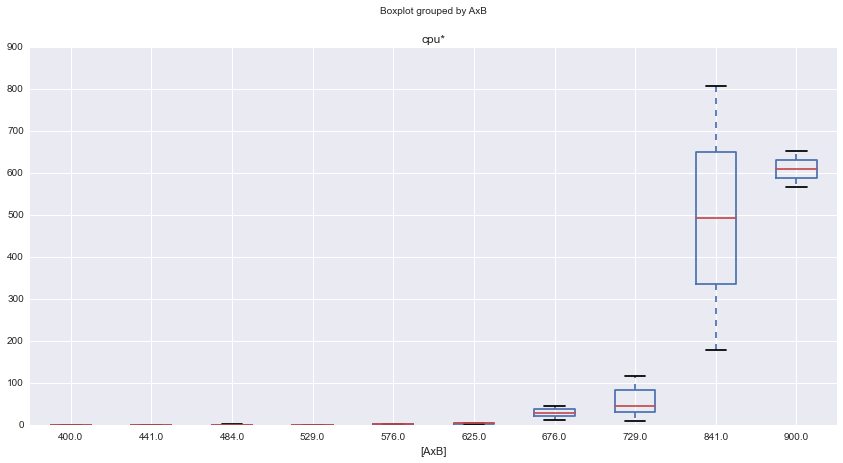

In [209]:
fig = matlab.boxplot(by=['AxB'], column='cpu*')
plt.show()

### Python CPU Times

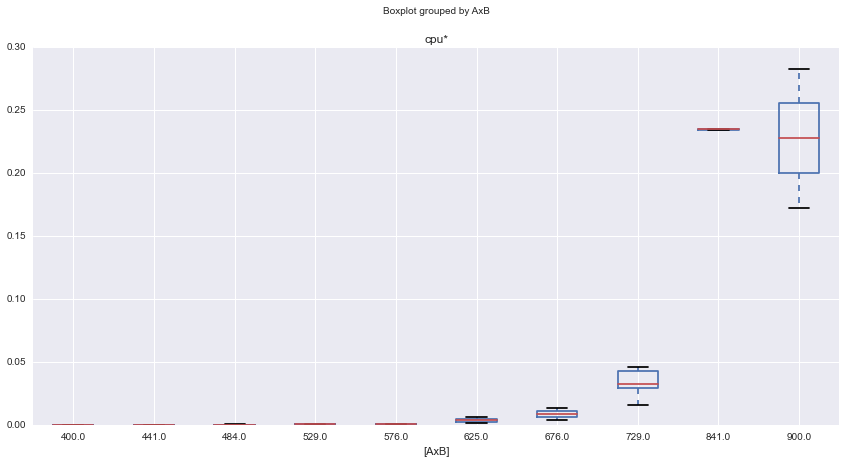

In [210]:
python.boxplot(by=['AxB'], column='cpu*')
plt.show()

### R CPU Times

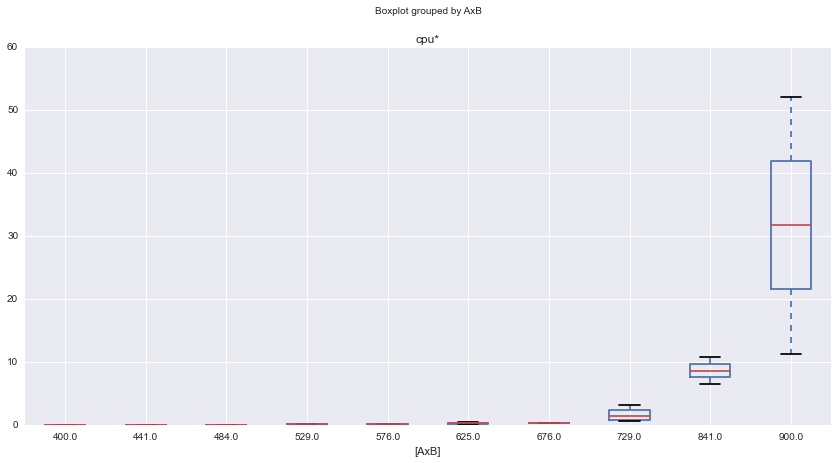

In [211]:
r.boxplot(by=['AxB'], column='cpu*')
plt.show()

### Scatter Plots Of Sequence

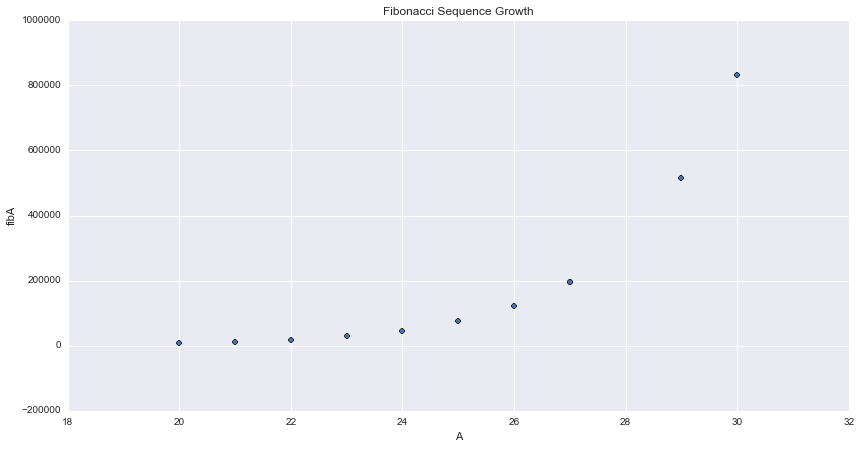

In [219]:
results.plot(kind='scatter', x='A', y='fibA', title="Fibonacci Sequence Growth")
plt.show()